In [69]:
# load all data and graph it
fileToLoad = "./faraday-flashlight-120bpm-1kohm-load.csv"
RWind = 60
RSense = (10 / 3)
ISenseGain = 25
VSenseDiv = (220 / (1200 + 220))

import PyQt5
import numpy as np
import matplotlib.pyplot as plt
import pandas
from scipy import signal

d = pandas.read_csv(fileToLoad)
print("CSV file has columns: ")
for (key, value) in d.items():
    print(key)

times = d["Time[s]"][1:].to_numpy().astype(np.float)
IHarvest = (d[" I_harvest"][1:].to_numpy().astype(np.float) / RSense) / ISenseGain
VHarvest = d[" V_harvest"][1:].to_numpy().astype(np.float) / VSenseDiv
Audio = d[" Audio"][1:].to_numpy().astype(np.float)
PHarvest = np.multiply(IHarvest, VHarvest)
VSource = VHarvest + (IHarvest * RWind)

firstdiff = np.zeros(500)
firstdiff[249] = 1
firstdiff[250] = -1
impulse = signal.convolve(signal.hann(500), firstdiff)

VSourceFiltered = signal.convolve(VSource, impulse)[:len(VSource)]

# Just use a simple hystersis based method to find beats
high = np.zeros(len(VSource)).astype(np.int)
hystereticLevels = [3, 2]
hystereticState = 0
beats = []
for i in range(1, len(VSource)):
    high[i] = VSource[i] > hystereticLevels[int(high[i - 1])]
    if ((high[i] == 1) and (high[i-1] == 0)):
        beats.append(i)

print(str(len(beats)) + " beats detected: " + str(beats))

CSV file has columns: 
Time[s]
 I_harvest
 V_harvest
 V_out
 Audio
36 beats detected: [244632, 263652, 501967, 520781, 548165, 744399, 793642, 993008, 1051858, 1238970, 1492251, 1538866, 1736188, 1786393, 1983409, 2239973, 2292658, 2487334, 2544409, 2737430, 2791300, 2980709, 3028247, 3049659, 3237550, 3290262, 3488964, 3739695, 3983401, 4239580, 4315975, 4489664, 4671294, 4725186, 4747598, 4772676]


<IPython.core.display.Javascript object>


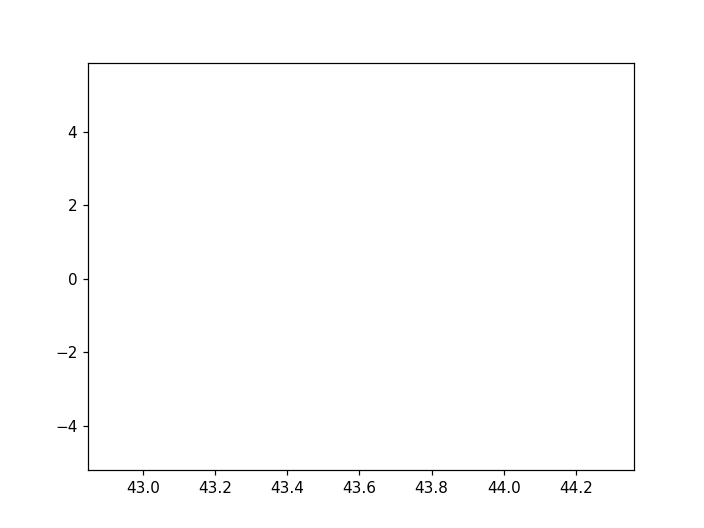

In [70]:
%matplotlib notebook
plt.plot(times, VSource, times, high, times, Audio)